In [1]:
# Matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from numpy.linalg import matrix_rank
import sys
sys.path.append('../src')
sys.path.append('../solvers')
from pendulum import Pendulum
from learning import KRidgeReg, NeuralNet, BuckyNet, KRidgeReg_struct
from nullspace_search import get_nondim_numbers, fit_allnondim
from helper_functions import prettify_results


## Get Rotating hoop data

In [2]:
output_type = 'dynamic'
nsamples=int(1e3)
tsteps=50
tend=10
phi_init=[np.pi/3, 0]

## Get solution
R = Pendulum(nsamples=nsamples, output_type=output_type, time_steps=tsteps, tend=tend, phi0=phi_init)
inputs, outputs = R.get_data()
dim_matrix = R.get_dim_matrix()


In [3]:
inputs.shape

(49000, 4)

In [15]:
## TODO: Set up hyperparameter search.

verbose = 1
num_nondim = 1
num_layers = 3
num_neurons = 40
activation = 'elu'
initializer = 'he_normal'
nepoch = 5000
patience = 30
test_size = 0.15
nullspace_loss = None # Set to weight \in [0, 1] if want to turn on
l1_reg = 0.0
l2_reg = 0.00001
adamlr = 0.003

B = BuckyNet(inputs, outputs, dim_matrix, num_nondim=num_nondim, num_layers=num_layers, num_neurons=num_neurons, activation=activation, verbose=verbose, initializer=initializer, nepoch=nepoch, patience=patience, test_size=test_size, nullspace_loss=nullspace_loss, l1_reg=l1_reg, l2_reg=l2_reg, adamlr=adamlr)


In [16]:
x = B.single_run()

Epoch 1/5000
1107/1107 [==============================] - 2s 1ms/step - loss: 2.5864 - root_mean_squared_error: 1.6020 - val_loss: 2.3104 - val_root_mean_squared_error: 1.5192
Epoch 2/5000
1107/1107 [==============================] - 1s 905us/step - loss: 2.2570 - root_mean_squared_error: 1.5013 - val_loss: 1.4321 - val_root_mean_squared_error: 1.1953
Epoch 3/5000
1107/1107 [==============================] - 1s 880us/step - loss: 1.1097 - root_mean_squared_error: 1.0486 - val_loss: 0.5319 - val_root_mean_squared_error: 0.7262
Epoch 4/5000
1107/1107 [==============================] - 1s 832us/step - loss: 0.3839 - root_mean_squared_error: 0.6134 - val_loss: 0.3545 - val_root_mean_squared_error: 0.5910
Epoch 5/5000
1107/1107 [==============================] - 1s 925us/step - loss: 0.2634 - root_mean_squared_error: 0.5078 - val_loss: 0.1308 - val_root_mean_squared_error: 0.3532
Epoch 6/5000
1107/1107 [==============================] - 1s 913us/step - loss: 0.1167 - root_mean_squared_error

In [17]:
# Need to find a way to do these automatically
# Say, we can divide by the largest number in the vector as a start (or simply avoid the smaller ones, the ones close to zero)
# Or as an over-kill, we can find the combination that has the least non-zero fractions.


x1_norm = x[:, 0]/x[1, 0]
Pi, names = R.get_dim_matrix(include_names=True)

print(x)
print('-------------')
print(x1_norm)
print('-------------')
print(Pi@x)


[[-0.00104539]
 [ 0.41401175]
 [-0.40850762]
 [-0.825873  ]]
-------------
[-0.00252504  1.         -0.98670536 -1.9948058 ]
-------------
[[ 0.00550413]
 [-0.00104539]
 [-0.00885779]]


In [18]:
from helper_functions import prettify_results

prettify_results(x1_norm, names, tol=0.1, max_degree=6)

## Known result is not guaranteed, but loss seems to be a good indicator

[-0.00252504  1.         -0.98670536 -1.9948058 ]
m : 0
L : 1
g : -1
t : -2


<IPython.core.display.Math object>

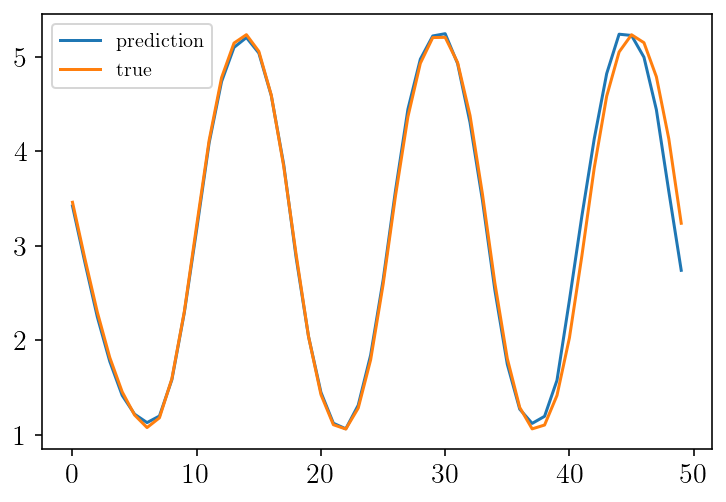

In [19]:
idx = 7000
pred = B.model.predict(np.log(inputs[idx:R.time_steps+idx, :]))
fig = plt.figure()
plt.plot(pred)
plt.plot(outputs[idx:R.time_steps+idx])
plt.legend(['prediction', 'true'])
plt.show()